## 1️⃣ 문제 정의

입력: 개인의 인구통계·직업 정보 (age, education, occupation 등)

출력:

P(income>50K)
P(income>50K)

모델: XGBoost (Gradient Boosting Tree)

데이터: UCI Adult Income Dataset

## 2️⃣ 데이터 로드

In [6]:
import pandas as pd

column_names = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income"
]


# 데이터 로드
df = pd.read_csv("./spark_adult_data.csv", header=None, names=column_names,skipinitialspace=True # 값 앞 공백 제거 (중요!)
)

df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


## 3️⃣ 타깃 변수 변환 (Label Encoding)

In [7]:
# 타깃 변수 이진화
df['income'] = df['income'].str.strip()
df['income_label'] = (df['income'] == '>50K').astype(int)

df[['income', 'income_label']].value_counts()

income  income_label
<=50K   0               759
>50K    1               240
Name: count, dtype: int64

## 4️⃣ 입력(X) / 타깃(y) 분리

In [8]:
X = df.drop(columns=['income', 'income_label'])
y = df['income_label']

## 5️⃣ 범주형 변수 처리 (One-Hot Encoding)

In [9]:
X_encoded = pd.get_dummies(X, drop_first=True)

## 6️⃣ 학습 / 테스트 데이터 분리

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## 7️⃣ XGBoost 모델 학습


In [11]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## 8️⃣ 예측 및 성능 평가

In [12]:
y_proba = model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       152
           1       0.66      0.65      0.65        48

    accuracy                           0.83       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.83      0.83      0.83       200

ROC-AUC: 0.8726699561403508


## 9️⃣ Feature Importance 확인

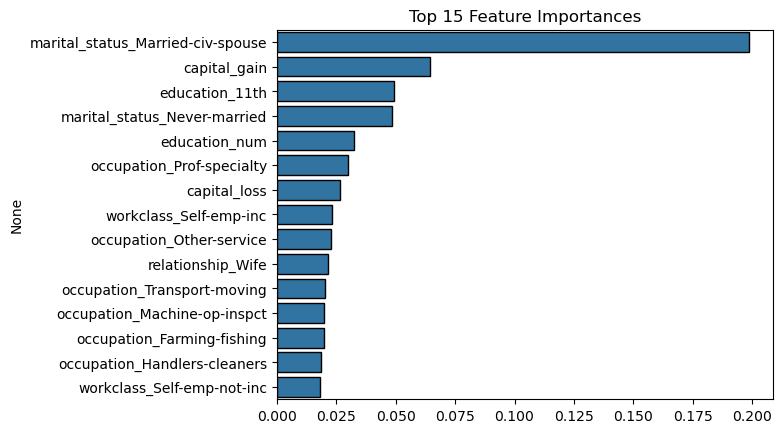

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

feat_importances = pd.Series(
    model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False).head(15)

sns.barplot(
    x=feat_importances.values,
    y=feat_importances.index,
    edgecolor='k'
)
plt.title("Top 15 Feature Importances")
plt.show()

## 🔟 (선택) SHAP 기반 해석 (Tree SHAP)

In [15]:
%pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 121.3 MB/s  0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [shap]2/3 [shap]]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.4.0 requires nvidia-ml-py3<8.0,>=7.352.0, which is not installed.
sagemaker-studio 1.1.4 requires pydynamodb>=0.7.4, which is not installed.
amazon-sagemaker-jupyter-ai-q-developer 1.2.8 requires numpy<=2.0.1, but you have numpy 2.3.5 which is incompatible.
amazon-sagemaker-sql-magic 0.1.4 requires numpy<2, but you have numpy 2.3.5 which is incompatible.
autogluon-multimodal 1.4.0 requires transformers[sentencepiece]<4.50,>=4.38.0

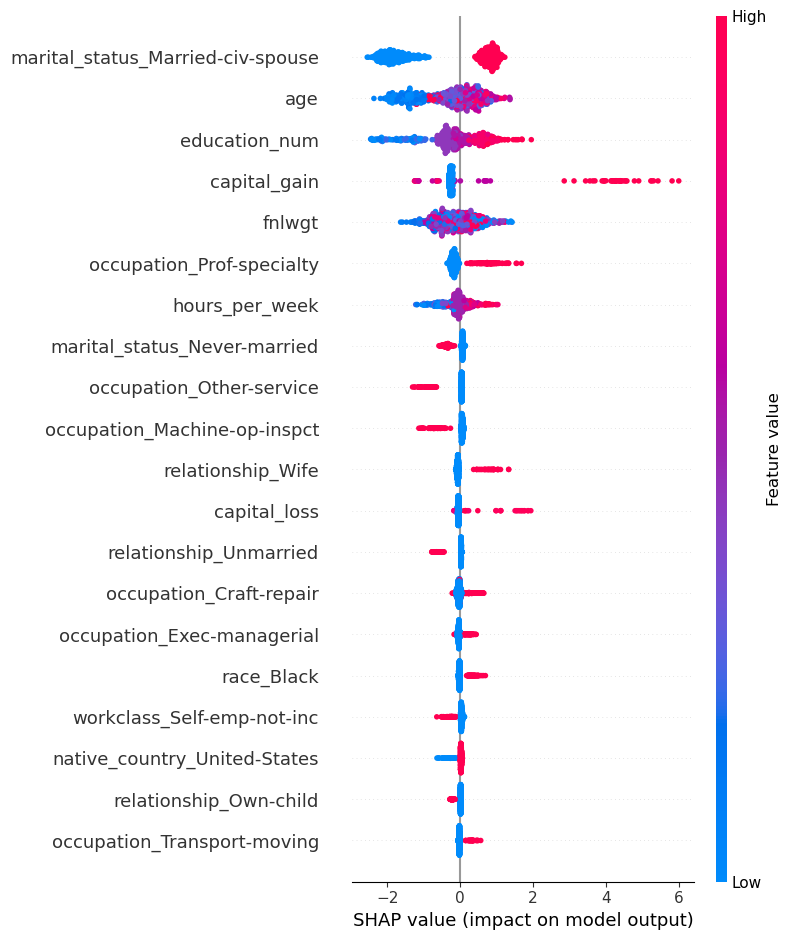

In [16]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

#### SHAP의 장점

개별 예측 설명 가능

“왜 이 사람이 고소득일 확률이 높은가?” 설명 가능

금융·정책·신뢰성 요구 환경에서 필수

### 정리

이 노트북을 완료했습니다. 실습의 다음 부분으로 이동하려면 다음을 수행합니다.

- 노트북 파일을 닫습니다.
- 실습 세션으로 돌아가 **결론**을 계속 진행합니다.